# Training a model

We start this tutorial on influence functions with training a classification model on MNIST. We follow the example from the [Flax](https://flax.readthedocs.io/en/latest/) library. For convenience we reproduce the training code in this colab so you can follow it step by step. We have modified the code to illustrate how to use multiple accelerators, i.e. we work with `jax.lax.pmap` instead of `jax.jit`.

In [ ]:
![ -d jax_influence ] || git clone --depth=1 https://github.com/google-research/jax_influence
!cd jax_influence && git pull
# Follow the installation instructions in pip_package/

In [ ]:
from jax_influence import batch_utils

In [ ]:
from flax import linen as nn
import flax
from flax.metrics import tensorboard
from flax.training import train_state
import jax
import jax.numpy as jnp
import ml_collections
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
import os

In [ ]:
# Enable eager exeuction and mask accelerators from TensorFlow.
# We use TensorFlow only for the data pipeline.
tf.compat.v1.enable_eager_execution()
tf.config.experimental.set_visible_devices([], 'GPU')

In [ ]:
#@title Directory for training.
workdir = 'flax_mnist_training' #@param {type:"string"}

In [ ]:
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    x = nn.log_softmax(x)
    return x


def cross_entropy_loss(logits, labels):
  return -jnp.mean(jnp.sum(labels * logits, axis=-1))


def per_example_cross_entropy_loss(logits, labels):
  xentropy = jnp.sum(labels * logits, axis=-1)
  return xentropy


def compute_metrics(logits, labels):
  one_hot = jax.nn.one_hot(labels, 10)
  loss = cross_entropy_loss(logits, one_hot)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [ ]:
def apply_model(state, images, labels):
  """Computes gradients, loss and accuracy for a single batch."""
  one_hot = jax.nn.one_hot(labels, 10)
  def loss_fn(params):
    logits = CNN().apply({'params': params}, images)
    loss = cross_entropy_loss(logits=logits, labels=one_hot)
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  grads = jax.lax.pmean(grads, 'batch')
  metrics = compute_metrics(logits, labels)
  metrics = jax.tree_map(lambda x: jax.lax.pmean(x, 'batch'), metrics)
  return grads, metrics['loss'], metrics['accuracy']

def update_model(state, grads):
  return state.apply_gradients(grads=grads)

In [ ]:
def train_epoch(state, train_ds, batch_size, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, len(train_ds['image']))
  perms = perms[:steps_per_epoch * batch_size]  # Skip incomplete batch.
  perms = perms.reshape((steps_per_epoch, batch_size))

  epoch_loss = []
  epoch_accuracy = []

  for perm in perms:
    batch = {'image': train_ds['image'][perm, ...], 'label': train_ds['label'][perm, ...]}
    batch = batch_utils.shard(batch)
    grads, loss, accuracy = jax.pmap(apply_model, axis_name='batch')(state, batch['image'], batch['label'])
    state = jax.pmap(update_model, axis_name='batch')(state, grads)
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy


def get_datasets():
  """Load MNIST train and test datasets into memory."""
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.
  return train_ds, test_ds


def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.sgd(config.learning_rate, config.momentum)
  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx)

In [ ]:
def train_and_evaluate(config: ml_collections.ConfigDict,
                       workdir: str) -> train_state.TrainState:
  """Execute model training and evaluation loop.

  Args:
    config: Hyperparameter configuration for training and evaluation.
    workdir: Directory where the tensorboard summaries are written to.

  Returns:
    The train state (which includes the `.params`).
  """
  train_ds, test_ds = get_datasets()
  rng = jax.random.PRNGKey(0)

  summary_writer = tensorboard.SummaryWriter(workdir)
  summary_writer.hparams(dict(config))

  rng, init_rng = jax.random.split(rng)
  state = create_train_state(init_rng, config)
  state = flax.jax_utils.replicate(state)
  test_batch = {'image':  test_ds['image'], 'label':  test_ds['label']}
  test_batch = batch_utils.shard(test_batch)
  for epoch in range(1, config.num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state, train_loss, train_accuracy = train_epoch(state, train_ds,
                                                    config.batch_size,
                                                    input_rng)

    _, test_loss, test_accuracy = jax.pmap(apply_model, axis_name='batch')(state, test_batch['image'], test_batch['label'])
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)
    print(
        'epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f, test_accuracy: %.2f'
        % (epoch, train_loss, train_accuracy * 100, test_loss,
           test_accuracy * 100))

    summary_writer.scalar('train_loss', train_loss, epoch)
    summary_writer.scalar('train_accuracy', train_accuracy, epoch)
    summary_writer.scalar('test_loss', test_loss, epoch)
    summary_writer.scalar('test_accuracy', test_accuracy, epoch)

  summary_writer.flush()
  return state

In [ ]:
def get_config():
  """Get the default hyperparameter configuration."""
  config = ml_collections.ConfigDict()

  config.learning_rate = 0.1
  config.momentum = 0.9
  config.batch_size = 128
  config.num_epochs = 2
  return config

In [ ]:
final_state = train_and_evaluate(get_config(), workdir)

epoch:  1, train_loss: 0.2712, train_accuracy: 91.77, test_loss: 0.0639, test_accuracy: 97.83
epoch:  2, train_loss: 0.0505, train_accuracy: 98.43, test_loss: 0.0387, test_accuracy: 98.66


In [ ]:
unrep_state = flax.jax_utils.unreplicate(final_state)
with tf.io.gfile.GFile(os.path.join(workdir, 'trained_params.flax'), 'wb') as f:
  f.write(flax.serialization.to_bytes(unrep_state.params)) 

# Running the Arnoldi Iteration

In this step we run the Arnoldi Iteration on the MNIST data. We will load the trained model and distill the top 100 projectors.

In [ ]:
from jax_influence import arnoldi
from jax_influence import batch_utils

from jax_influence import linalg_utils
from jax_influence import function_factory

In [ ]:
# We first create an infinite iterator for the training dataset.
@tf.function
def normalize_image(record):
  out = record.copy()
  out['image'] = tf.cast(out['image'], 'float32') / 255.
  return out 

train_it = iter(tfds.builder('mnist').as_dataset(split='train').map(normalize_image).repeat().batch(256*10))
# Here we take care of converting tf.Tensor to jnp.array.
train_it = batch_utils.BatchIterator(train_it, [batch_utils.maybe_convert_to_array])

In [ ]:
# Load trained parameters.
with tf.io.gfile.GFile(os.path.join(workdir, 'trained_params.flax'), 'rb') as f:
  params = flax.serialization.msgpack_restore(f.read())
  # Flax likes the parameters to be stored in a Frozen dictionary.
  params = flax.core.FrozenDict(params)

In [ ]:
# We now need to define a loss function to be used to estimate the model's
# Hessian.
def loss_fn(params, batch):
  labels = batch['label']
  images = batch['image']
  one_hot = jax.nn.one_hot(labels, 10)
  logits = CNN().apply({'params': params}, images)
  loss = cross_entropy_loss(logits=logits, labels=one_hot)
  return loss

In [ ]:
# Create the HVP (Hessian-Vector Product) estimator.

# First create the HVP step on a single batch.
# Here we do the full model parameters so we pass params_select_fn=None.
# Set the mean_across_hosts to True as we write code for multiple devices.
hvp_step = function_factory.create_hvp_on_sample(loss_fn, mean_across_hosts=True)
# A batch consists of 2560 images but to make the computation less intensive we
# split it into 10 micro batches.
hvp_step = function_factory.create_accumulator(hvp_step, num_micro_batches=10, do_average=True)
hvp_step = jax.pmap(hvp_step, 'batch')
# To create the estimator we now take the step, and bind the parameters and the training data iterator.
hvp_est_fn = function_factory.create_hvp_estimator(hvp_step, handle_p_mapping=True, params=params, data_iterator=train_it)

In [ ]:
# Create a random vector to start the Arnoldi iteration.
start_params = linalg_utils.random_initialization(params, seed=jax.random.PRNGKey(12))

In [ ]:
# Perform the Arnoldi iteration; we save the intermediate results on the host RAM in order to not
# fill the accelerators RAM, hence move_to_host=True.
arnoldi_result = arnoldi.arnoldi_iter(hvp_est_fn, linalg_utils.inner_product, params, n_iters=200, move_to_host=True)

In [ ]:
# Distill the result of the Arnoldi iteration into eigenvalues and eigenvectors.
eigens = arnoldi.distill(arnoldi_result, top_k=100)

In [ ]:
# Save the distilled eigenvalues/vectors.
with tf.io.gfile.GFile(os.path.join(workdir, 'projectors.flax'), 'wb') as f:
  f.write(flax.serialization.to_bytes(eigens))

# Influence estimation
In this step we show how to use the obtained projectors to compute influence. We consider two cases: self-influence for the test data and influence of the training data on the test data.

In [ ]:
from jax_influence import utils
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
# (Re)-load trained parameters.
with tf.io.gfile.GFile(os.path.join(workdir, 'trained_params.flax'), 'rb') as f:
  params = flax.serialization.msgpack_restore(f.read())
  # Flax likes the parameters to be stored in a Frozen dictionary.
  params = flax.core.FrozenDict(params)

In [ ]:
train_ds, test_ds = get_datasets()

In [ ]:
# We corrupt about 20% of the labels in the test dataset.
seed = jax.random.PRNGKey(15)
seed1, seed2 = jax.random.split(seed)
flip_label = jax.random.uniform(seed1, test_ds['label'].shape) < .23
random_label = jax.random.choice(seed2, a=10, shape=test_ds['label'].shape)
new_label = jnp.where(flip_label, random_label, test_ds['label'])
new_label = np.array(new_label)
is_mislabeled = (new_label != test_ds['label']).astype('int32')
print('% of mislabeled data:', np.mean(is_mislabeled))
test_ds['label'] = new_label

% of mislabeled data: 0.2068


In [ ]:
# We load the projections from the previous step and use the top 20 eigenvalues.
# We discard negative eigenvalues sorting on the value instead of the absolute value: use_abs=False.
eigval, eigvec = utils.get_eigvals_eigvecs(os.path.join(workdir, 'projectors.flax'), eigvals_slice=(0,20), use_abs=False)

In [ ]:
# We now need to define a loss function which is per_example.
def per_example_loss_fn(params, batch):
  labels = batch['label']
  images = batch['image']
  one_hot = jax.nn.one_hot(labels, 10)
  logits = CNN().apply({'params': params}, images)
  loss = per_example_cross_entropy_loss(logits=logits, labels=one_hot)
  return loss

In [ ]:
# To compute the projections we need to construct the Jacobian-Vector Product (JVP) function on each example.
jvp_fn = function_factory.create_jvp_on_each_example(per_example_loss_fn)
jvp_fn = jax.pmap(jvp_fn, axis_name='batch')

In [ ]:
train_ds_sharded = batch_utils.shard(train_ds)
test_ds_sharded = batch_utils.shard(test_ds)

In [ ]:
eigvec_rep = flax.jax_utils.replicate(eigvec)
params_rep = flax.jax_utils.replicate(params)

In [ ]:
projections_test = jnp.zeros((test_ds['image'].shape[0], len(eigvec_rep)))
for i, eigvec in enumerate(eigvec_rep):
  prj = jvp_fn(params_rep, eigvec, test_ds_sharded)
  prj = prj.flatten()
  projections_test = projections_test.at[:, i].set(prj)

In [ ]:
# This code attempts the computation on the full train data. This should work
# on TPUv3. If you get OOM errors use the code in next cell.
projections_train = jnp.zeros((train_ds['image'].shape[0], len(eigvec_rep)))
for i, eigvec in enumerate(eigvec_rep):
  prj = jvp_fn(params_rep, eigvec, train_ds_sharded)
  prj = prj.flatten()
  projections_train = projections_train.at[:, i].set(prj)

In [ ]:
# The code here assumes train_ds will be split into batches. Use this code
# if your accelerator memory is not enought to process the whole train data.
num_splits = 5
split_size = train_ds['image'].shape[0]//num_splits
projections_train = [jnp.zeros((split_size, len(eigvec_rep))) for _ in range(num_splits)]
for split in range(num_splits):
  for i, eigvec in enumerate(eigvec_rep):
    min_idx = split * split_size
    max_idx = (split+1)*split_size
    sliced = jax.tree_map(lambda x: x[:,min_idx:max_idx], train_ds_sharded)
    prj = jvp_fn(params_rep, eigvec, sliced)
    prj = prj.flatten()
    projections_train[split] = projections_train[split].at[:, i].set(prj)
projections_train = np.concatenate(projections_train)

In [ ]:
# Let us try to see how well self-influence performs at recalling the mislabeled points.
self_influence = jnp.einsum('bd,d,bd -> b', projections_test, 1.0/eigval, projections_test)
print('Self-influence AUC:', metrics.roc_auc_score(is_mislabeled, self_influence))
print('Self-influece AP:', metrics.average_precision_score(is_mislabeled, self_influence))

Self-influence AUC: 0.9975904350421524
Self-influece AP: 0.9868385708937291


In [ ]:
# Let us pick a mislabeled test point.
# Here we normalize the influence by the projections norm as discussed in the
# paper.
test_id = np.where(is_mislabeled)[0][45]
norm = jnp.einsum('bi,bi->b', projections_train, projections_train)
norm = jnp.sqrt(1/(norm+1e-6))
influence_norm = jnp.einsum('b, bi,i,i->b', norm, projections_train, projections_test[test_id], 1/eigval)
proponents = jnp.argsort(-influence_norm)[:10]
opponents = jnp.argsort(influence_norm)[:10]

In [ ]:
def show_image(img, ax=None, title=None, cmap=None, fontsize=12):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...], cmap=cmap)
  if title:
    ax.set_xlabel(title, fontsize=fontsize)
  ax.set_xticks([])
  ax.set_yticks([])

In [ ]:
def show_image_list(list_images, explain_image, list_titles=None, grid=False, figsize=(15, 20), fontsize=14, 
                    cols = ["Proponents", "Opponents"]):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    fontsize: int
        Fontsize.
    '''


    def retrieve_image(img_id, is_test=False):
      data = train_ds
      if is_test:
        data = test_ds
      return data['image'][img_id]

    def retrieve_title(img_id, is_test=False):
      data = train_ds
      if is_test:
        data = test_ds
      return str(data['label'][img_id])

    num_cols  = len(list_images)
    num_rows  = len(list_images[0])

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols+1, figsize=figsize)
    show_image(retrieve_image(explain_image, is_test=True), ax=axes[int(num_rows/2), 0], title=None, cmap="Greys")
    axes[int(num_rows/2), 0].set_title("Image to explain: " + retrieve_title(explain_image, is_test=True), fontsize=fontsize)
    axes[int(num_rows/2), 0].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
    axes[int(num_rows/2), 0].grid(grid)
    axes[int(num_rows/2), 0].set_aspect('equal')
    for i in range(num_rows):
      if i is not int(num_rows/2):
        axes[i, 0].set_visible(False)

    for ax, col in zip(axes[0][1:], cols):
      ax.set_title(col, fontsize=fontsize)

    axes[0,1].set_ylabel("Top 1", rotation=0, fontsize=fontsize, labelpad = 100)
    axes[num_rows-1,1].set_ylabel("Top 5", rotation=0, fontsize=fontsize, labelpad = 100)

    for i in range(num_rows):
      for j in range(num_cols):

          img    = list_images[j][i]
          cmap = "Blues"
          if j >= 1:
            cmap = "Reds"
          
          show_image(retrieve_image(img), ax=axes[i, j+1], title=retrieve_title(img), cmap=cmap, fontsize=fontsize)
          axes[i, j+1].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
         
          axes[i, j+1].grid(grid)
          axes[i, j+1].set_aspect('equal')
        # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.savefig('proponents_opponents.png')

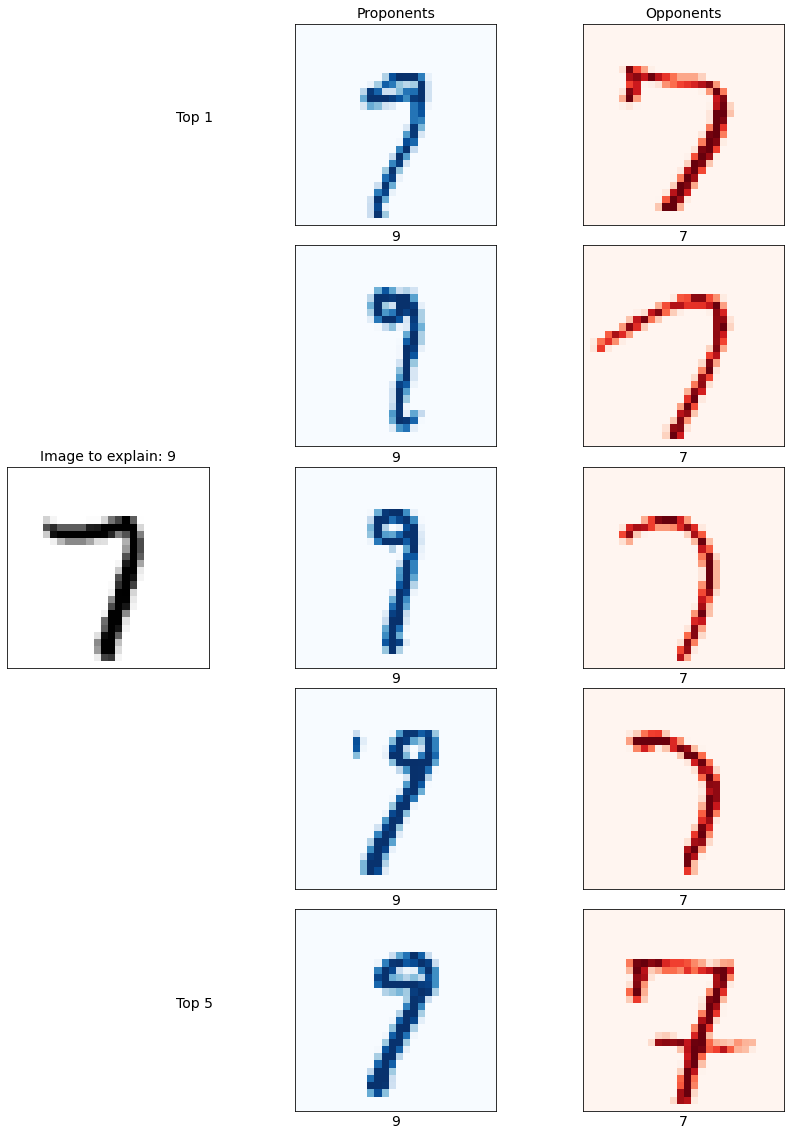

In [ ]:
list_images = [proponents[:5], opponents[:5]]
show_image_list(list_images, test_id)
